In [1]:
import numpy as np
import h5py
import os,pickle
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splinalg

from es_appm_445_2019.utils import get_A,get_rhs,get_init,iter_solve,residual
from es_appm_445_2019.red_black_utils import convert_vec_to_rb,convert_mat_to_rb
from es_appm_445_2019.jacobi import jacobi
from es_appm_445_2019.weighted_jacobi import weighted_jacobi
from es_appm_445_2019.gauss_sidel import gauss_sidel
from es_appm_445_2019.sor import sor
from es_appm_445_2019.ssor import ssor

In [2]:
#StackOverflow
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def get_eigendist(eigenvals,eigenvecs,n):
    w_ = np.zeros((n*n,2))
    _f = np.fft.fftfreq(n,d=1/n)
    fx,fy = np.meshgrid(_f,_f)
    f  = np.sqrt(fx**2 + fy**2)
    f  = radial_profile(f,(n//2,n//2))

    for v in range(n*n):
        _t = np.abs(np.fft.fftshift(np.fft.fft2(eigvecs[:,v].reshape(n,n))))
        t = radial_profile(_t,(n//2,n//2))
        if len((np.where(t==np.max(t)))[0])==1:
            i = np.where(t==np.max(t))
        else:
            i = np.where(t==np.max(t))[0]
        i = int(i[0])
        w_[v][0] = np.abs(eigvals[v])
        w_[v][1] = f[i]
    return w_

In [3]:
meth_dict = {}

In [4]:
meth_dict[1] = 'jacobi'
meth_dict[2] = 'weighted_jacobi'
meth_dict[3] = 'gauss_sidel'
meth_dict[4] = 'red_black_gauss_sidel'
meth_dict[5] = 'sym_gauss_sidel'
meth_dict[6] = 'sor'
meth_dict[7] = 'ssor'

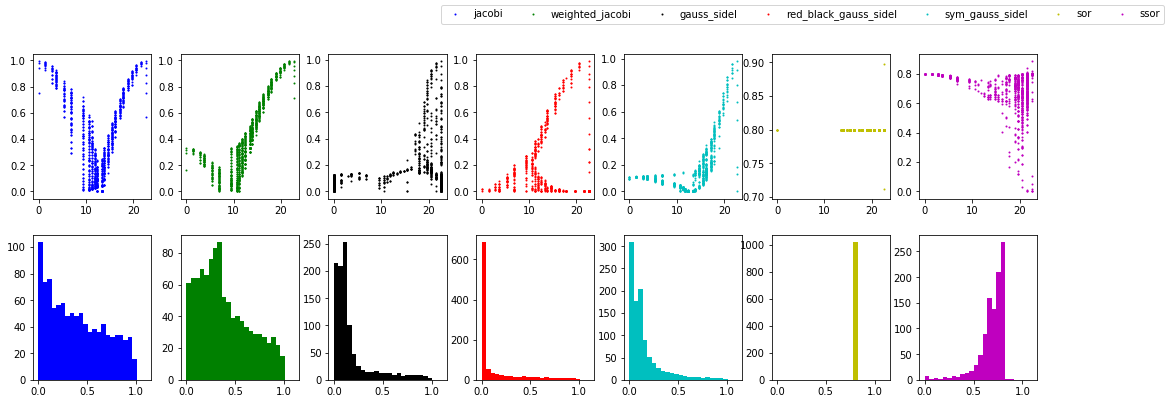

In [10]:
init = 3

its = 50

#plt.rcParams["figure.figsize"] = (6,20)
fig,axarr = plt.subplots(2,7)

n = 32
k = 0

A = get_A(n,k) 
b = get_rhs(n)
x = get_init(n,init)

bins = np.linspace(0,1.1,25)
c_ = ['b','g','k','r','c','y','m']
s_ = 1

for m in np.arange(1,8):
    if m==1:
        meth = jacobi
        G,b1 = meth(A,b)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l1 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])
        
        
    if m==2:
        meth = weighted_jacobi
        w = 2/3
        G,b1 = meth(A,b,w)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l2 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])

        
    if m==3:
        meth = gauss_sidel
        G,b1 = meth(A,b)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l3 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])

        
        
    if m==4:
        meth = gauss_sidel
        x_ = convert_vec_to_rb(x,n)
        b_ = convert_vec_to_rb(b,n)
        A_ = convert_mat_to_rb(A,n)
        G,b1 = meth(A_,b_)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l4 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])

        
        
    if m==5:
        meth = ssor
        w = 1
        G,b1 = meth(A,b,w)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l5 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])
        
    if m==6:
        meth = sor
        w = 1.8
        G,b1 = meth(A,b,w)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l6 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])
        
    if m==7:
        meth = ssor
        w = 1.8
        G,b1 = meth(A,b,w)
        eigvals,eigvecs = np.linalg.eig(G.toarray())
        w_ = get_eigendist(eigvals,eigvecs,n)
        e_ = np.sort(np.abs(np.linalg.eigvals(G.toarray())))
        l7 = axarr[0,m-1].scatter(w_[:,1],w_[:,0],s=s_,c=c_[m-1])
        axarr[1,m-1].hist(e_,bins,color=c_[m-1])
        
fig.legend((l1,l2,l3,l4,l5,l6,l7),('jacobi','weighted_jacobi','gauss_sidel','red_black_gauss_sidel','sym_gauss_sidel','sor','ssor'), ncol=7 )

fig.subplots_adjust(hspace=0.25)
fig.subplots_adjust(wspace=0.25)
fig.set_size_inches(18, 6, forward=True)
plt.show()